In [1]:
import os
import pandas as pd
import geopandas as gpd
from tqdm import tqdm

ERROR 1: PROJ: proj_create_from_database: Open of /project/cper_neon_aop/conda_envs/hls_nrt_env/share/proj failed


In [2]:
df_wts_early = pd.read_csv('../data/ground/cattle_weights/Monthly_ADG_all_2020Feb26.csv',
                           parse_dates=['on_date', 'off_date'])
df_wts_late = pd.read_csv('../data/ground/cattle_weights/cper_28day_weights_2020-2024_2024-10-22.csv',
                          parse_dates=['Sample.Date'])
df_stock_late = pd.read_csv('../data/ground/cattle_weights/cper_28day_stocking_rate_2020-2024_2024-10-22.csv')

In [3]:
df_wts = pd.read_csv('../data/ground/cattle_weights/cper_28day_clean_weights_2000-to-present_2024-10-28.csv',
                     parse_dates=['Date'])
df_stock = pd.read_csv('../data/ground/cattle_weights/cper_28day_stocking_rate_2000-present_2024-10-28.csv')

In [4]:
df_wts['ID'] = df_wts[['Tag', 'Tag.Color']].astype(str).apply(lambda x: '_'.join(x), axis=1)

In [5]:
df_wts = df_wts[~df_wts[['Date', 'Weight', 'Weight_Shrunk']].isnull().any(axis=1)]

In [6]:
keep_cols = ['Year', 'Pasture', 'ID', 'on_date', 'on_wt_raw', 'on_wt']

In [7]:
df_id_list = []
for idxs, group in tqdm(df_wts.groupby(['Year', 'Pasture', 'ID'])):
    df_tmp_list = []
    if len(group) >= 2:
        for i in range(len(group)-1):
            df_tmp = pd.DataFrame(group.iloc[[i]]).set_index([pd.Index([i])])
            df_tmp = df_tmp.rename(columns={'Date': 'on_date',
                                            'Weight': 'on_wt_raw',
                                            'Weight_Shrunk': 'on_wt'})[keep_cols]
            df_tmp.loc[i, 'off_date'] = group.iloc[i+1]['Date']
            df_tmp.loc[i, 'off_wt_raw'] = group.iloc[i+1]['Weight']
            df_tmp.loc[i, 'off_wt'] = group.iloc[i+1]['Weight_Shrunk']
            df_tmp_list.append(df_tmp)
        df_id = pd.concat(df_tmp_list, ignore_index=True)
        df_id_list.append(df_id)
    else:
        print(len(group))
        print(idxs)
        continue
    

 73%|███████▎  | 1268/1740 [00:16<00:06, 73.30it/s]

1
(2019, '23E', '1219_white')


 79%|███████▉  | 1381/1740 [00:18<00:04, 72.89it/s]

1
(2020, '23E', '862_white')


 80%|████████  | 1398/1740 [00:18<00:04, 74.63it/s]

1
(2020, '23W', '930_white')


 97%|█████████▋| 1681/1740 [00:21<00:00, 88.92it/s] 

1
(2024, '19N', '3781_white')


100%|██████████| 1740/1740 [00:22<00:00, 77.28it/s]


In [8]:
df_wts_cln = pd.concat(df_id_list, ignore_index=True)

In [9]:
df_wts_cln

,Year,Pasture,ID,on_date,on_wt_raw,on_wt,off_date,off_wt_raw,off_wt
0,2000,15E,907_Brown,2000-05-19,598.0,598.000,2000-06-15,664.0,664.000
1,2000,15E,907_Brown,2000-06-15,664.0,664.000,2000-07-14,686.0,686.000
2,2000,15E,907_Brown,2000-07-14,686.0,686.000,2000-08-11,774.0,774.000
3,2000,15E,908_Purple,2000-05-19,732.0,732.000,2000-06-15,796.0,796.000
4,2000,15E,908_Purple,2000-06-15,796.0,796.000,2000-07-14,840.0,840.000
...,...,...,...,...,...,...,...,...,...
7901,2024,23W,962_white,2024-08-08,786.0,715.260,2024-09-07,802.0,745.058
7902,2024,23W,995_white,2024-05-17,722.0,671.460,2024-06-13,834.0,761.442
7903,2024,23W,995_white,2024-06-13,834.0,761.442,2024-07-11,835.0,762.355
7904,2024,23W,995_white,2024-07-11,835.0,762.355,2024-08-08,898.0,817.180


In [10]:
df_wts_cln = pd.merge(df_wts_cln, df_stock[['Year', 'Pasture', 'Allocation.number']],
         how='left', on=['Year', 'Pasture'])
df_wts_cln = df_wts_cln.rename(columns={'Allocation.number': 'on_ct'})

df_wts_cln['Past_Year'] = df_wts_cln.apply(lambda x: '_'.join([x['Pasture'], str(x['Year'])]), axis=1)

df_wts_cln = df_wts_cln.rename(columns={'Pasture': 'PastureID'})

In [11]:
#df_wts_late_cln = pd.merge(df_wts_late_cln, df_stock_late[['Year', 'Pasture', 'Allocation.number']],
#         how='left', on=['Year', 'Pasture'])
#df_wts_late_cln = df_wts_late_cln.rename(columns={'Allocation.number': 'on_ct'})

#df_wts_late_cln['Past_Year'] = df_wts_late_cln.apply(lambda x: '_'.join([x['Pasture'], str(x['Year'])]), axis=1)

#df_wts_late_cln = df_wts_late_cln.rename(columns={'Pasture': 'PastureID'})

#df_wts_all = pd.concat([df_wts_early, df_wts_late_cln])

In [12]:
df_wts_all = df_wts_cln

In [13]:
df_wts_all.groupby('Year').apply(lambda x: x['PastureID'].unique())

Year
2000         [15E, 23E, 23W]
2001         [15E, 23E, 23W]
2002         [15E, 23E, 23W]
2003         [15E, 23E, 23W]
2004         [15E, 23E, 23W]
2005         [15E, 23E, 23W]
2006         [15E, 23E, 23W]
2007         [15E, 23E, 23W]
2008         [15E, 23E, 23W]
2009         [15E, 23E, 23W]
2010         [15E, 23E, 23W]
2011         [15E, 23E, 23W]
2012         [15E, 23E, 23W]
2013         [15E, 23E, 23W]
2014         [15E, 23E, 23W]
2015         [15E, 23E, 23W]
2016         [15E, 23E, 23W]
2017         [15E, 23E, 23W]
2018         [15E, 23E, 23W]
2019    [15E, 19N, 23E, 23W]
2020    [15E, 19N, 23E, 23W]
2021    [15E, 19N, 23E, 23W]
2022    [15E, 19N, 23E, 23W]
2023    [15E, 19N, 23E, 23W]
2024    [15E, 19N, 23E, 23W]
dtype: object

In [14]:
df_wts_all['period_days'] = (df_wts_all['off_date'] - df_wts_all['on_date']).dt.days

In [15]:
df_wts_all['period_days'].unique()

array([27, 29, 28, 26, 54, 57, 25, 56, 33, 30, 40, 41, 45, 55, 38, 22, 16,
       37, 31, 24, 44, 68, 86])

In [16]:
df_wts_all[df_wts_all['period_days'] > 40]['Past_Year'].unique()

array(['15E_2001', '23W_2001', '15E_2003', '23E_2003', '23W_2003',
       '15E_2006', '23E_2006', '23W_2006', '15E_2007', '23E_2007',
       '23W_2007', '15E_2008', '23E_2008', '23W_2008', '23E_2009',
       '15E_2011', '23E_2012', '15E_2013', '23E_2016', '15E_2017',
       '15E_2018', '23W_2019', '15E_2020', '19N_2020', '15E_2022',
       '23E_2022', '23E_2024'], dtype=object)

In [17]:
df_wts_all['adg'] = (df_wts_all['off_wt'] - df_wts_all['on_wt']) / df_wts_all['period_days']

In [18]:
df_wts_all.to_csv('../data/ground_cln/cper_28day_weights_2000_2024.csv', index=False)

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [20]:
df_wts_all = pd.read_csv('../data/ground_cln/cper_28day_weights_2000_2024.csv',
                         parse_dates=['on_date', 'off_date'])

In [21]:
cper = gpd.read_file('../data/ground/boundaries/cper_pastures_2022_w_exclosures_spk.shp')

In [22]:
df_fq = pd.read_csv('../data/training/cper_pasture_2000_2024_fq_predictions.csv', 
                    parse_dates=['date'])
df_bm = pd.read_csv('../summarize_pastures/outputs/cper_pasture_biomass_2000_2024.csv',
                    parse_dates=['date'])

In [23]:
cper = cper.to_crs(32613)
cper = cper.rename(columns={'Past_Name_': 'PastureID'})
cper = cper.dissolve('PastureID').reset_index()
cper['area_ha'] = cper.area *10e-5

In [24]:
df_wts_all['on_date'] = pd.to_datetime(df_wts_all['on_date'])
df_wts_all['off_date'] = pd.to_datetime(df_wts_all['off_date'])

In [25]:
#df_wts_all[df_wts_all['adg'] > 5.0].sort_values('adg', ascending=False).to_csv(
#    '../data/ground/cattle_weights/error_checks/high_28day_adg.csv', index=False)
#df_wts_all[df_wts_all['adg'] < -5.0].sort_values('adg', ascending=False).to_csv(
#    '../data/ground/cattle_weights/error_checks/low_28day_adg.csv', index=False)

In [26]:
#with pd.option_context('display.max_rows', 150):
#    display(df_wts_all[(df_wts_all['Year']>1900)&(df_wts_all['adg'] > 5.0)].sort_values('on_date', ascending=False))

In [27]:
#df_wts_all[df_wts_all['adg'] < -2.0].sort_values('adg')

In [28]:
#df_wts_all = df_wts_all[(df_wts_all['adg'] < 5.0) & (df_wts_all['adg'] > -5.0)].copy()

In [29]:
df_wts_all['outlier_adg_upr'] = df_wts_all.groupby(['PastureID', 'off_date'])['adg'].transform(lambda x: x.mean()+x.std()*3)
df_wts_all['outlier_adg_lwr'] = df_wts_all.groupby(['PastureID', 'off_date'])['adg'].transform(lambda x: x.mean()-x.std()*3)
df_wts_all['outlier_adg'] = df_wts_all.apply(
    lambda x: 1 if (x['adg'] > x['outlier_adg_upr']) or (x['adg'] < x['outlier_adg_lwr']) else 0, axis=1)

In [30]:
df_wts_all[df_wts_all['outlier_adg'] == 1].sort_values('adg')

,Year,PastureID,ID,on_date,on_wt_raw,on_wt,off_date,off_wt_raw,off_wt,on_ct,Past_Year,period_days,adg,outlier_adg_upr,outlier_adg_lwr,outlier_adg
7477,2024,15E,1001_white,2024-06-13,946.0,863.698,2024-07-11,762.0,695.706,30,15E_2024,28,-5.999714,5.341362,-3.934907,1
7285,2023,23E,111_white,2023-09-07,1076.0,999.604,2023-09-29,982.0,913.260,26,23E_2023,22,-3.924727,3.739113,-3.699351,1
1805,2007,15E,603_Brown,2007-06-14,666.0,666.000,2007-07-12,600.0,600.000,20,15E_2007,28,-2.357143,4.731285,-1.588428,1
1275,2005,15E,447_brown,2005-06-16,846.0,846.000,2005-07-14,782.0,782.000,20,15E_2005,28,-2.285714,6.534485,-1.898771,1
5597,2018,23W,68_white,2018-08-31,968.0,880.880,2018-09-28,896.0,833.280,16,23W_2018,28,-1.700000,4.221951,-1.586415,1
765,2003,23E,211_Brown,2003-09-12,902.0,902.000,2003-10-08,858.0,858.000,25,23E_2003,26,-1.692308,2.705534,-1.631816,1
2133,2008,15E,711_Brown,2008-07-10,862.0,862.000,2008-08-07,820.0,820.000,20,15E_2008,28,-1.500000,4.103455,-0.832026,1
7293,2023,23E,149_white,2023-07-13,934.0,852.742,2023-08-10,902.0,820.820,26,23E_2023,28,-1.140071,4.251881,-1.103711,1
6698,2021,23E,468_yellow,2021-06-17,758.0,692.054,2021-07-15,730.0,666.490,30,23E_2021,28,-0.913000,5.010573,-0.330886,1
7672,2024,23E,1239_white,2024-07-11,915.0,835.395,2024-08-08,894.0,813.540,45,23E_2024,28,-0.780536,2.527494,-0.767673,1


In [31]:
df_wts_all['outlier_on_wt_upr'] = df_wts_all.groupby(['PastureID', 'off_date'])['on_wt'].transform(lambda x: x.mean()+x.std()*3)
df_wts_all['outlier_on_wt_lwr'] = df_wts_all.groupby(['PastureID', 'off_date'])['on_wt'].transform(lambda x: x.mean()-x.std()*3)
df_wts_all['outlier_on_wt'] = df_wts_all.apply(
    lambda x: 1 if (x['on_wt'] > x['outlier_on_wt_upr']) or (x['on_wt'] < x['outlier_on_wt_lwr']) else 0, axis=1)

df_wts_all['outlier_off_wt_upr'] = df_wts_all.groupby(['PastureID', 'off_date'])['off_wt'].transform(lambda x: x.mean()+x.std()*3)
df_wts_all['outlier_off_wt_lwr'] = df_wts_all.groupby(['PastureID', 'off_date'])['off_wt'].transform(lambda x: x.mean()-x.std()*3)
df_wts_all['outlier_off_wt'] = df_wts_all.apply(
    lambda x: 1 if (x['off_wt'] > x['outlier_off_wt_upr']) or (x['off_wt'] < x['outlier_off_wt_lwr']) else 0, axis=1)

In [32]:
df_wts_all[df_wts_all['outlier_on_wt'] == 1].sort_values('on_wt')

,Year,PastureID,ID,on_date,on_wt_raw,on_wt,off_date,off_wt_raw,off_wt,on_ct,...,adg,outlier_adg_upr,outlier_adg_lwr,outlier_adg,outlier_on_wt_upr,outlier_on_wt_lwr,outlier_on_wt,outlier_off_wt_upr,outlier_off_wt_lwr,outlier_off_wt
7659,2024,23E,1112_white,2024-08-08,592.0,538.72,2024-09-07,638.0,592.702,45,...,1.799400,3.187406,-0.757475,0,901.953868,541.208976,1,937.981979,580.540777,0
1279,2005,15E,464_white,2005-05-17,762.0,762.00,2005-06-16,842.0,842.000,20,...,2.666667,6.740848,-1.100848,0,758.479617,457.320383,1,875.038677,509.961323,0
7496,2024,15E,1237_white,2024-05-17,930.0,864.90,2024-06-13,990.0,903.870,30,...,1.443333,7.233690,-2.088371,0,849.640235,407.595765,1,945.133433,451.026167,0
2269,2008,23E,743_Brown,2008-07-10,942.0,942.00,2008-08-07,992.0,992.000,30,...,1.785714,2.408081,-0.012843,0,940.942179,541.457821,1,979.167860,570.298806,1
2270,2008,23E,743_Brown,2008-08-07,992.0,992.00,2008-09-03,986.0,986.000,30,...,-0.222222,2.200287,-0.328682,0,979.167860,570.298806,1,998.021942,601.978058,0


In [33]:
df_wts_all[df_wts_all['outlier_off_wt'] == 1].sort_values('off_wt')

,Year,PastureID,ID,on_date,on_wt_raw,on_wt,off_date,off_wt_raw,off_wt,on_ct,...,adg,outlier_adg_upr,outlier_adg_lwr,outlier_adg,outlier_on_wt_upr,outlier_on_wt_lwr,outlier_on_wt,outlier_off_wt_upr,outlier_off_wt_lwr,outlier_off_wt
7658,2024,23E,1112_white,2024-07-11,560.0,511.28,2024-08-08,592.0,538.72,45,...,0.980000,2.527494,-0.767673,0,887.095233,506.889767,0,904.085066,539.174934,1
2268,2008,23E,743_Brown,2008-05-16,774.0,774.00,2008-07-10,942.0,942.00,30,...,3.054545,3.357697,1.948970,0,786.381978,404.151356,0,940.942179,541.457821,1
2269,2008,23E,743_Brown,2008-07-10,942.0,942.00,2008-08-07,992.0,992.00,30,...,1.785714,2.408081,-0.012843,0,940.942179,541.457821,1,979.167860,570.298806,1
2271,2008,23E,743_Brown,2008-09-03,986.0,986.00,2008-10-13,1084.0,1084.00,30,...,2.450000,2.944879,-0.068213,0,998.021942,601.978058,0,1079.355350,635.711317,1


In [34]:
df_wts_all_cln = df_wts_all[(df_wts_all['outlier_adg'] == 0) & 
(df_wts_all['outlier_on_wt'] == 0) & 
(df_wts_all['outlier_off_wt'] == 0)]

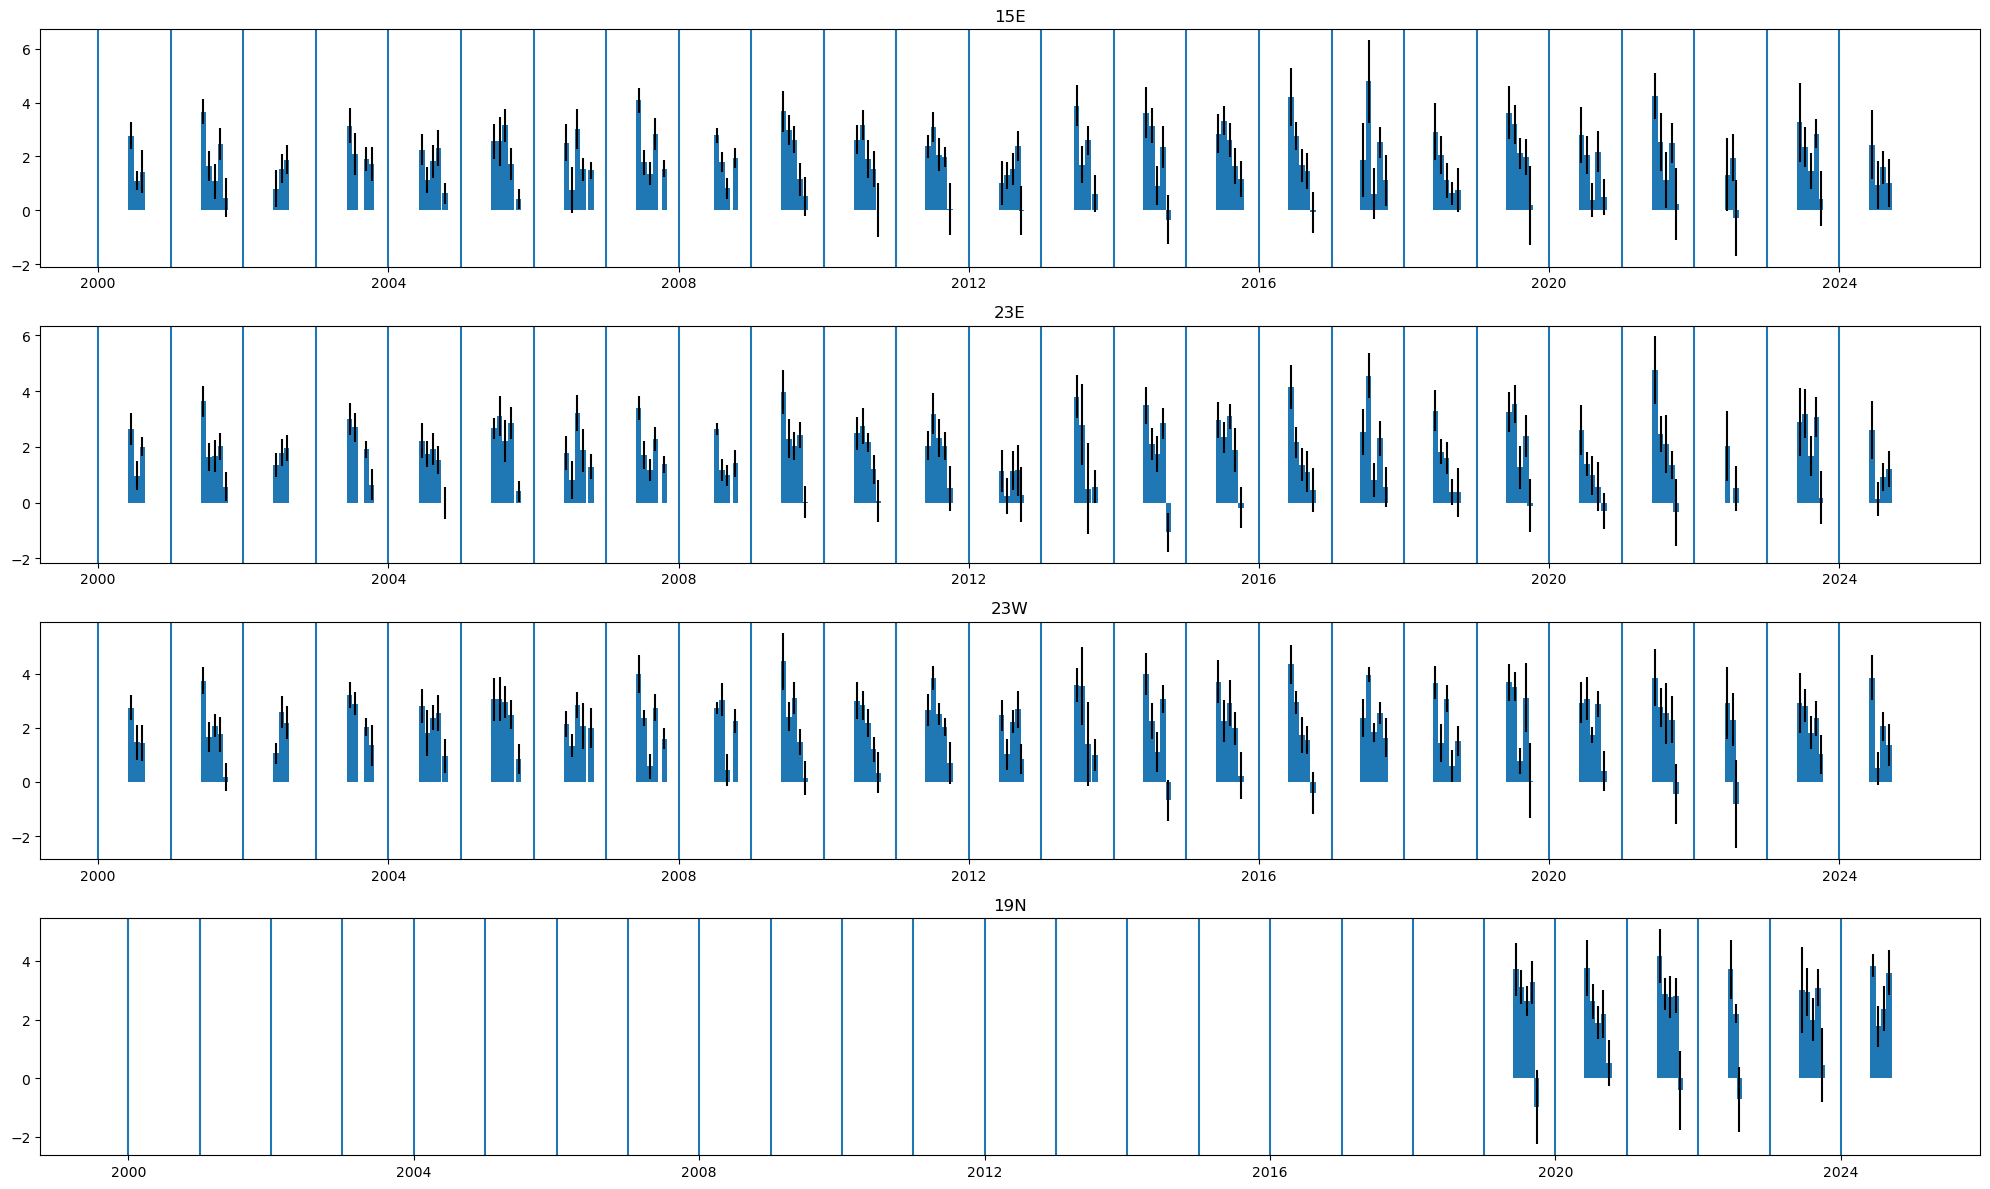

In [35]:
past_list =  ['15E', '23E', '23W', '19N']
fig, axs = plt.subplots(nrows=len(past_list), figsize=(20, 12))
for idx, past in enumerate(past_list):
    df_sub = df_wts_all_cln[df_wts_all_cln['PastureID'] == past]
    axs.flatten()[idx].bar(df_sub.groupby('off_date')['adg'].mean().index,
                           df_sub.groupby('off_date')['adg'].mean().values,
                           width=datetime.timedelta(days=28),
                           yerr=df_sub.groupby('off_date')['adg'].std().values)
    for yr in df_wts_all['Year'].unique():
        axs.flatten()[idx].axvline(datetime.datetime(yr, 1, 1))
        axs.flatten()[idx].set_title(past)
plt.tight_layout()

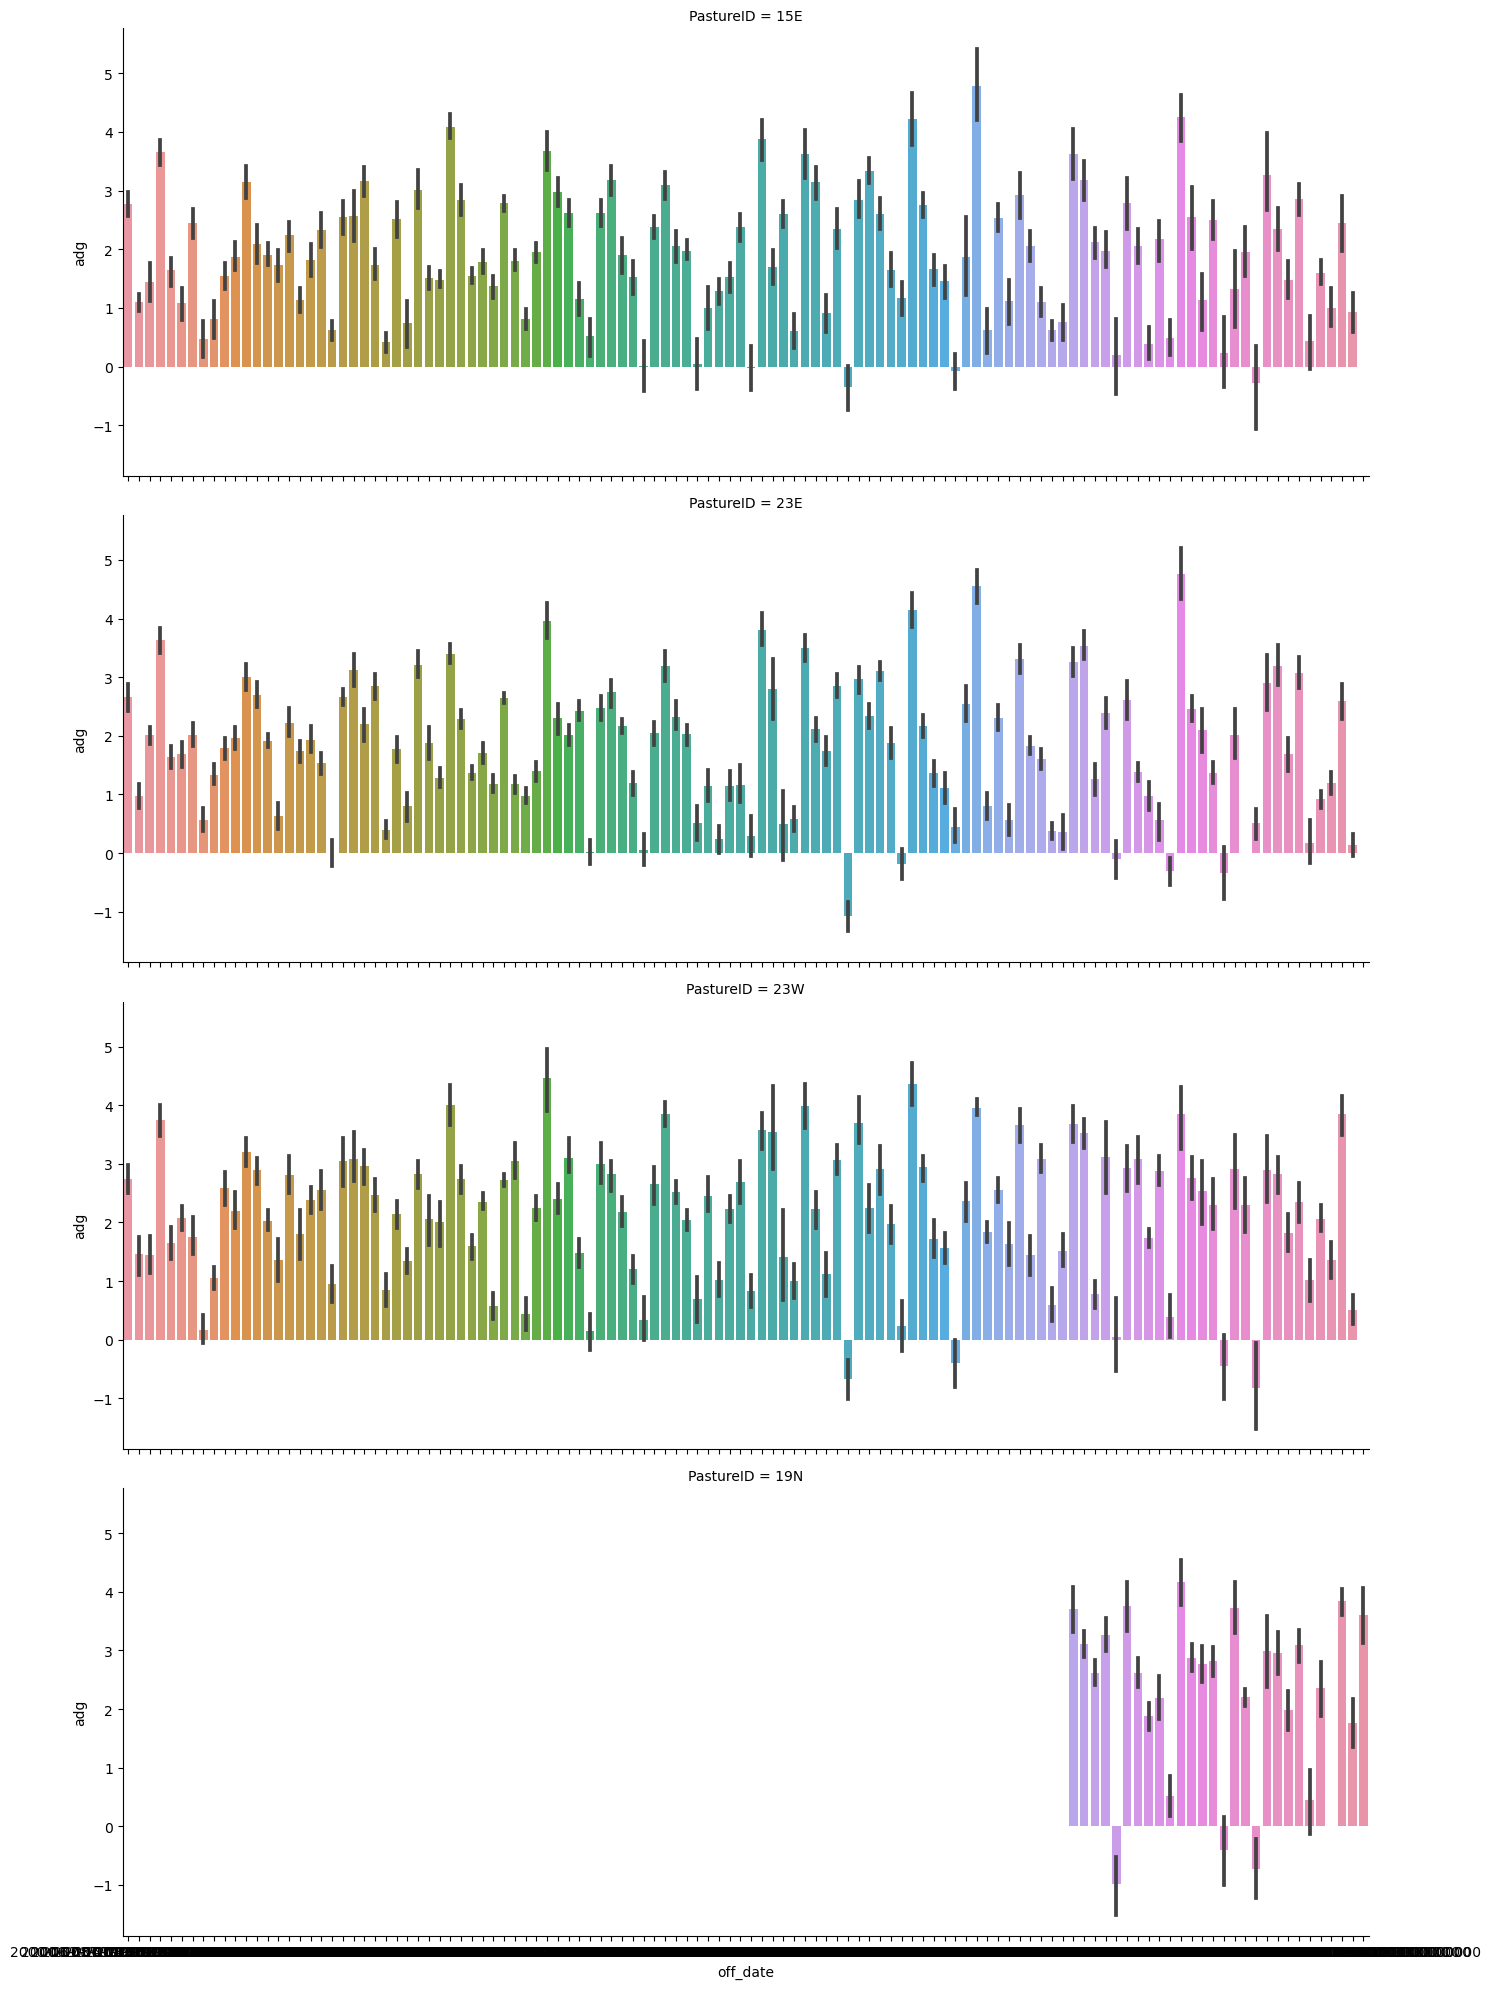

In [36]:
p = sns.catplot(kind='bar', x='off_date', y='adg', 
            data=df_wts_all_cln[df_wts_all_cln['PastureID'].isin(['15E', '23E', '23W', '19N'])],
            aspect=3.0,
            row='PastureID')
#for ax in p.axes.flatten():
#    for yr in df_wts_all['Year'].unique():
#        ax.axvline(pd.to_datetime(datetime.datetime(yr, 1, 1)))

In [37]:
df_wts_all_mean = df_wts_all_cln.groupby(['Year', 'PastureID', 'on_date', 'off_date']).mean().reset_index()
df_wts_all_mean['num_animals'] = df_wts_all_cln.groupby(['Year', 'PastureID', 'on_date', 'off_date'])['ID'].count().values

In [38]:
df_wts_all_mean[df_wts_all_mean['num_animals'] < 10]

,Year,PastureID,on_date,off_date,on_wt_raw,on_wt,off_wt_raw,off_wt,on_ct,period_days,...,outlier_adg_upr,outlier_adg_lwr,outlier_adg,outlier_on_wt_upr,outlier_on_wt_lwr,outlier_on_wt,outlier_off_wt_upr,outlier_off_wt_lwr,outlier_off_wt,num_animals
13,2001,15E,2001-08-10,2001-10-03,738.00,738.0000,820.00,820.00000,20.0,54.0,...,2.644275,-1.700116,0.0,1141.419880,635.180120,0.0,1141.308664,664.091336,0.0,1
21,2001,23W,2001-05-17,2001-07-13,792.00,792.0000,954.00,954.00000,15.0,57.0,...,3.314071,-0.020181,0.0,1013.387691,464.212309,0.0,1091.364532,492.368801,0.0,1
126,2009,23E,2009-06-12,2009-08-06,558.00,558.0000,646.00,646.00000,30.0,55.0,...,3.524456,0.507071,0.0,983.432795,415.187895,0.0,1047.736879,466.745879,0.0,1
152,2011,15E,2011-06-09,2011-08-04,592.00,592.0000,772.00,772.00000,20.0,56.0,...,3.912278,0.209150,0.0,931.060990,564.339010,0.0,958.923877,660.876123,0.0,1
172,2012,23E,2012-05-17,2012-07-12,634.00,634.0000,700.00,700.00000,30.0,56.0,...,2.150776,-1.672205,0.0,856.490548,500.042786,0.0,858.648162,513.485172,0.0,1
183,2013,15E,2013-05-30,2013-07-25,596.00,596.0000,850.00,776.05000,20.0,56.0,...,3.726489,-0.326857,0.0,911.773997,509.839403,0.0,965.004313,560.801287,0.0,1
233,2016,23E,2016-07-07,2016-08-30,810.00,739.5300,902.00,820.82000,30.0,54.0,...,3.274186,-1.045828,0.0,998.512562,611.621438,0.0,1041.106693,629.774641,0.0,1
242,2017,15E,2017-05-11,2017-07-06,607.25,564.7425,832.25,759.84425,23.0,56.0,...,9.400359,0.174154,0.0,824.934176,434.406867,0.0,969.741573,625.547297,0.0,8
261,2018,15E,2018-08-02,2018-09-28,805.00,732.5500,811.00,754.23000,26.0,57.0,...,3.217243,-1.687024,0.0,947.124059,617.375941,0.0,992.084128,616.958949,0.0,2
291,2019,23W,2019-07-11,2019-09-05,924.00,843.6120,972.00,902.98800,17.0,56.0,...,6.950688,-0.726214,0.0,948.339447,708.207053,0.0,1076.869817,757.672933,0.0,1


In [39]:
df_wts_all_mean = df_wts_all_mean[df_wts_all_mean['num_animals'] > 10]
df_wts_all_mean = df_wts_all_mean[df_wts_all_mean['period_days'] <= 40]

In [40]:
df_wts_all_mean = df_wts_all_mean[df_wts_all_mean['Year'] != 2013]

In [41]:
df_wts_all_mean = pd.merge(df_wts_all_mean, cper[['PastureID', 'area_ha']], how='left', on='PastureID')

In [42]:
df_wts_all_mean['area_ha'] = df_wts_all_mean['area_ha'].round(2)
df_wts_all_mean['on_ct_ha'] = df_wts_all_mean['on_ct']/df_wts_all_mean['area_ha']
df_wts_all_mean['on_au'] = df_wts_all_mean['on_wt']/1000*df_wts_all_mean['on_ct']
df_wts_all_mean['on_au_ha'] = df_wts_all_mean['on_au']/df_wts_all_mean['area_ha']

In [43]:
for idx, row in tqdm(df_wts_all_mean.iterrows(), total=len(df_wts_all_mean)):
    fq_mean = df_fq[(df_fq['date'].between(row['on_date'],
                                           row['off_date'], 
                                           inclusive='neither')) &
    (df_fq['Pasture'] == row['PastureID'])][['CP_pred', 'DOM_pred']].mean()
    bm_mean = df_bm[(df_bm['date'].between(row['on_date'],
                                           row['off_date'], 
                                           inclusive='neither')) &
    (df_bm['Pasture'] == row['PastureID'])][['Biomass_kg_ha']].mean()
    df_wts_all_mean.loc[idx, 'CP'] = fq_mean['CP_pred']
    df_wts_all_mean.loc[idx, 'DOM'] = fq_mean['DOM_pred']
    df_wts_all_mean.loc[idx, 'Biomass_kg_ha'] = bm_mean['Biomass_kg_ha']

100%|██████████| 342/342 [00:09<00:00, 35.89it/s]


In [44]:
df_wts_all_mean[df_wts_all_mean.isnull().any(axis=1)]['Year'].unique()

array([2012])

In [45]:
df_wts_all_mean = df_wts_all_mean.dropna(how='any')

In [46]:
df_wts_all_mean.value_counts(['Year']).sort_index()

Year
2000     9
2001    15
2002     9
2003     9
2004    15
2005    15
2006    12
2007    12
2008     9
2009    15
2010    15
2011    15
2014    15
2015    15
2016    15
2017    15
2018    15
2019    20
2020    20
2021    20
2022    10
2023    20
2024    12
dtype: int64

In [47]:
df_wts_all_mean['forage_kg_au'] = df_wts_all_mean.apply(lambda x: x['Biomass_kg_ha']*x['area_ha']*0.25/x['on_au'],
                                                        axis=1)

<AxesSubplot:>

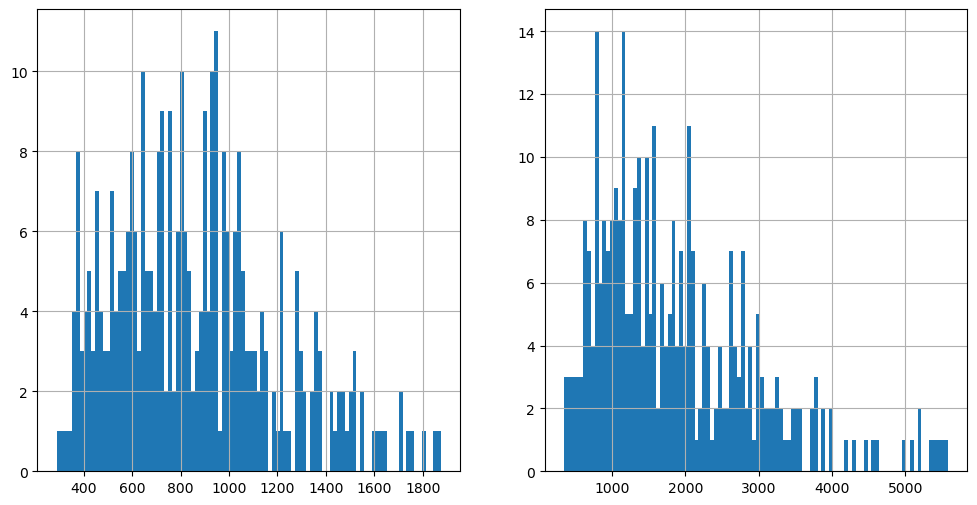

In [48]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
df_wts_all_mean['Biomass_kg_ha'].hist(bins=100, ax=axs[0])
df_wts_all_mean['forage_kg_au'].hist(bins=100, ax=axs[1])

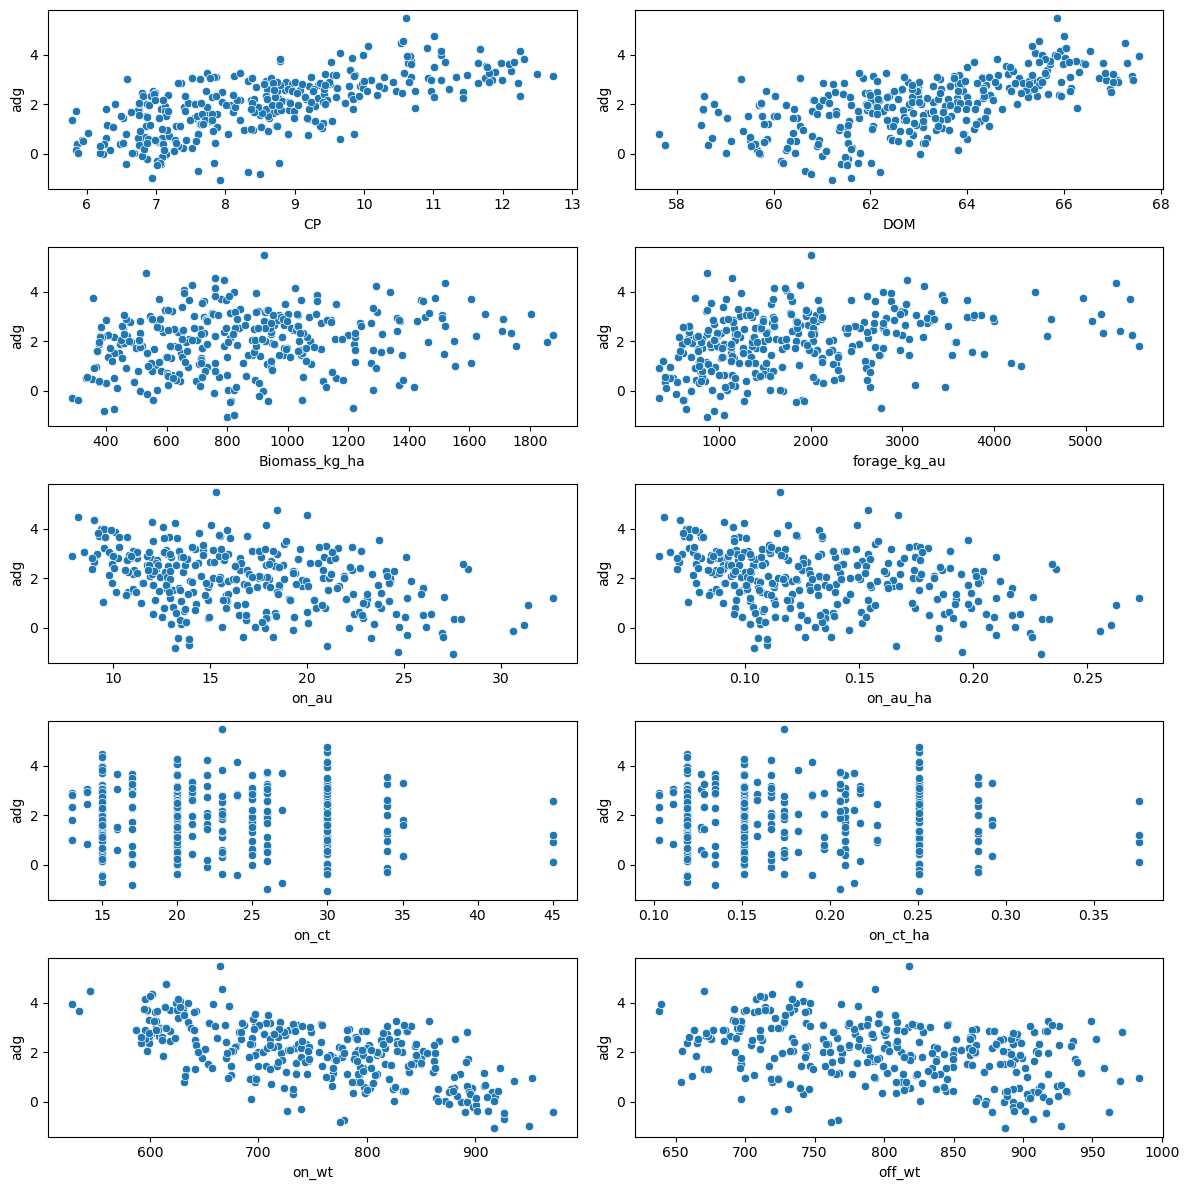

In [50]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(12,12))
sns.scatterplot(x='CP', y='adg', data=df_wts_all_mean, ax=axs[0,0])
sns.scatterplot(x='DOM', y='adg', data=df_wts_all_mean, ax=axs[0,1])
sns.scatterplot(x='Biomass_kg_ha', y='adg', data=df_wts_all_mean, ax=axs[1,0])
sns.scatterplot(x='forage_kg_au', y='adg', data=df_wts_all_mean, ax=axs[1,1])
sns.scatterplot(x='on_au', y='adg', data=df_wts_all_mean, ax=axs[2,0])
sns.scatterplot(x='on_au_ha', y='adg', data=df_wts_all_mean, ax=axs[2,1])
sns.scatterplot(x='on_ct', y='adg', data=df_wts_all_mean, ax=axs[3,0])
sns.scatterplot(x='on_ct_ha', y='adg', data=df_wts_all_mean, ax=axs[3,1])
sns.scatterplot(x='on_wt', y='adg', data=df_wts_all_mean, ax=axs[4,0])
sns.scatterplot(x='off_wt', y='adg', data=df_wts_all_mean, ax=axs[4,1])
fig.tight_layout()

In [51]:
df_wts_all_mean['period'] = df_wts_all_mean.groupby(
    ['Year', 'PastureID'])['on_date'].transform(
    lambda x: x.reset_index().index.values).astype('str')
#df_wts_all_mean['period_simp'] = df_wts_all_mean['period'].apply(lambda x: '5' if int(x)>5 else x)

In [52]:
df_wts_all_mean = df_wts_all_mean.reset_index()

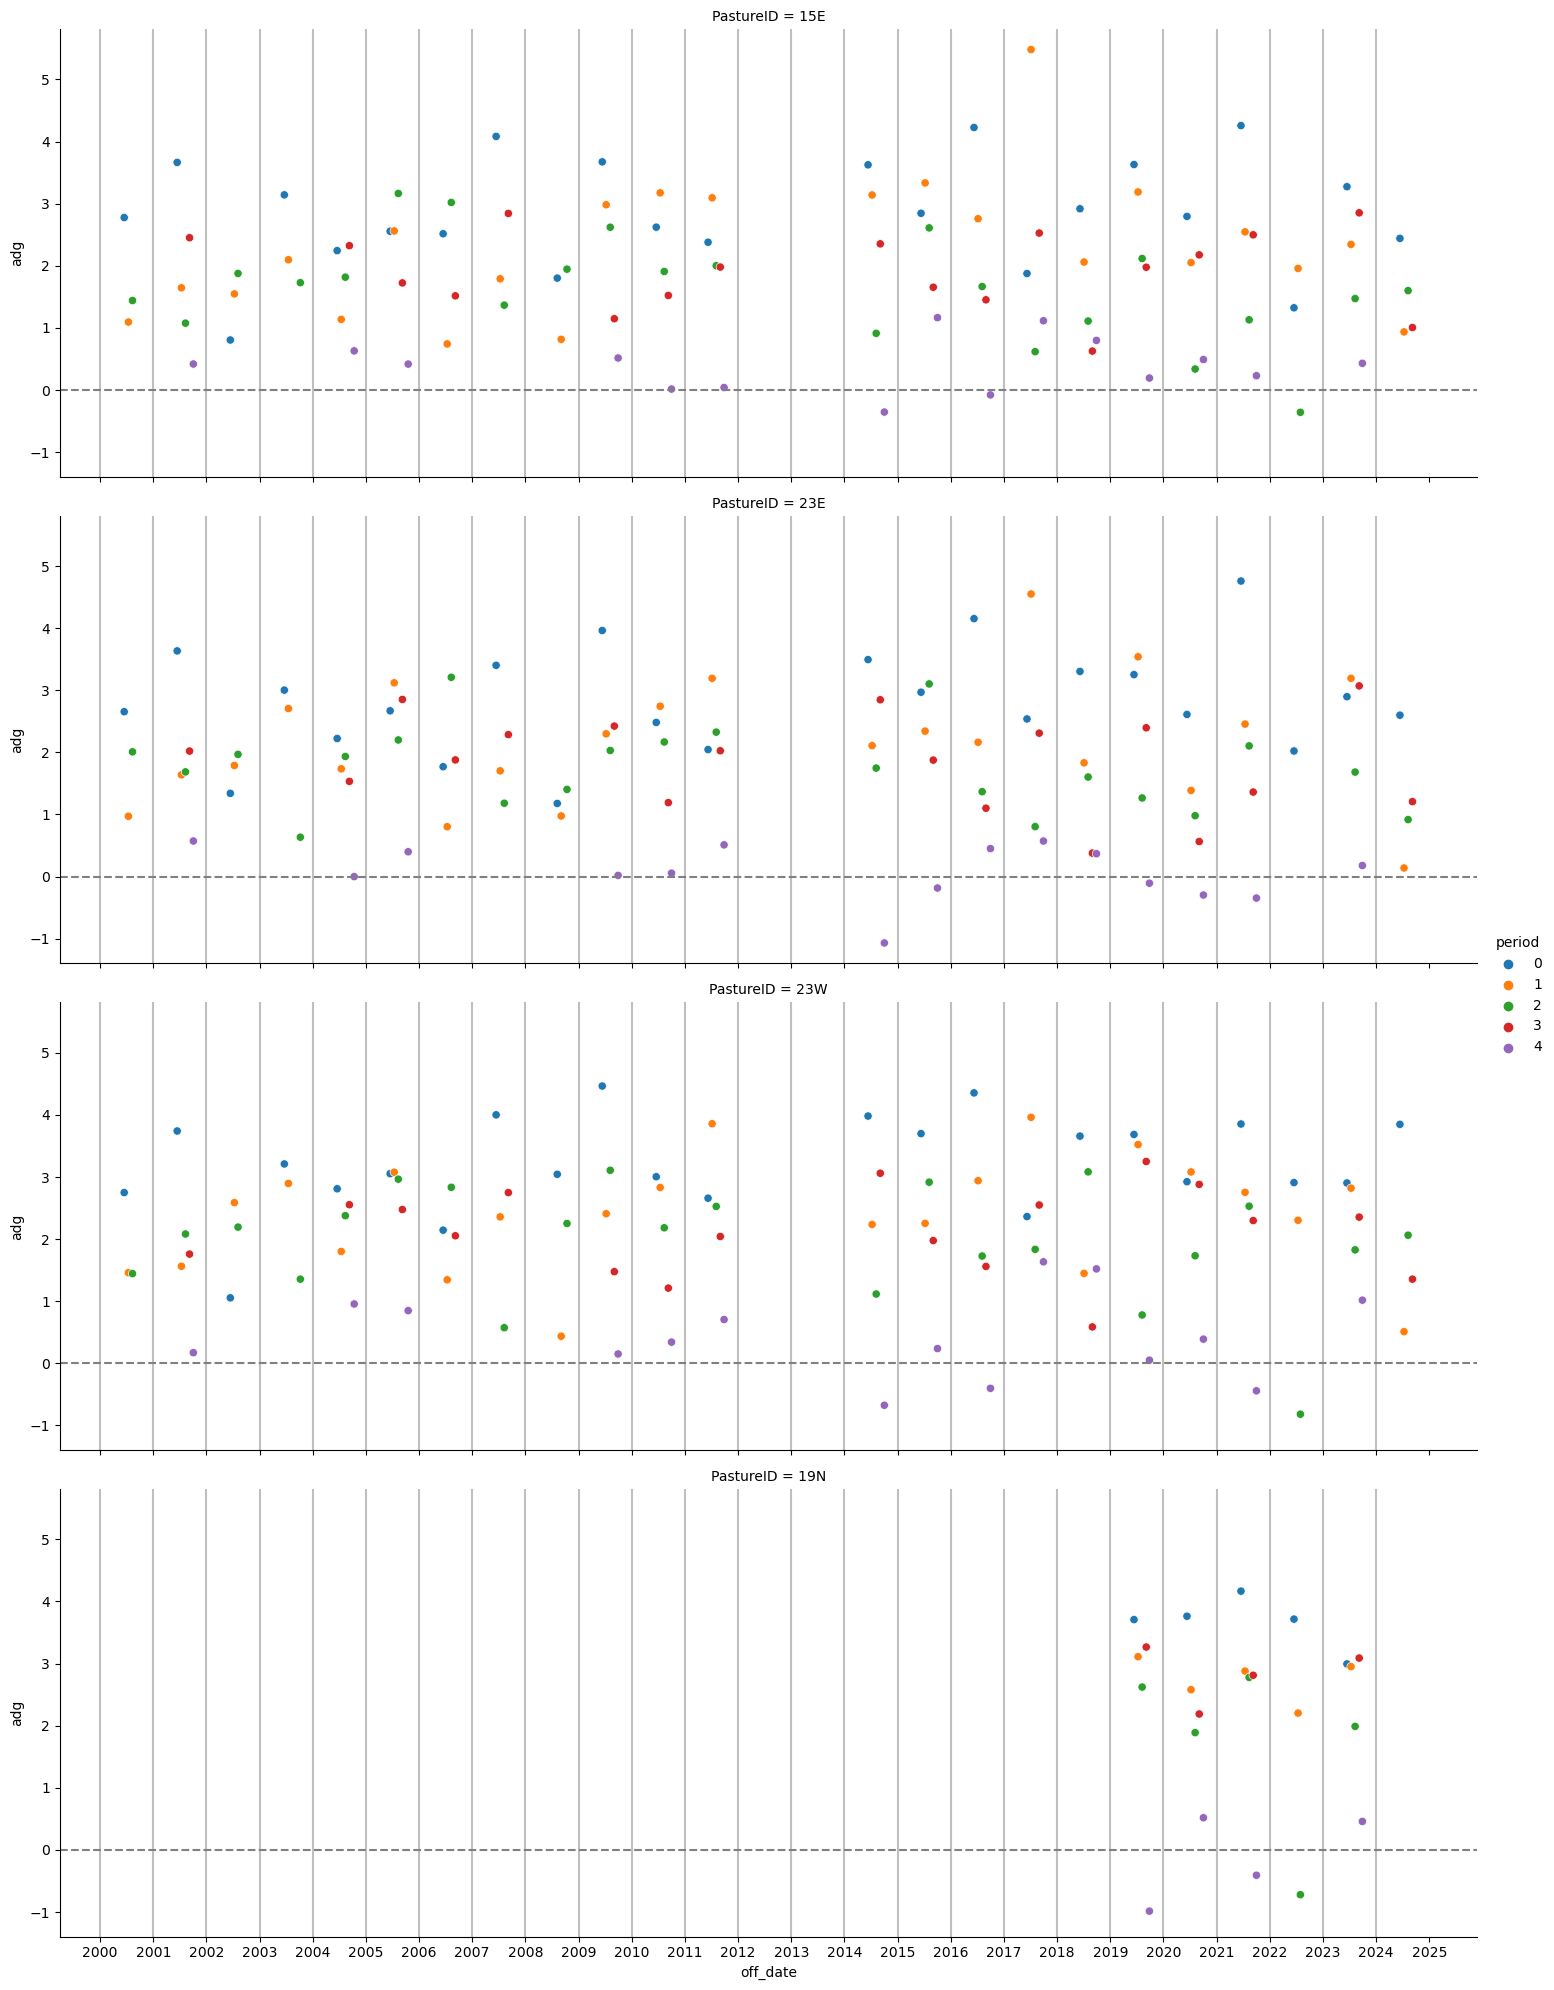

In [53]:
from matplotlib.dates import YearLocator
p = sns.relplot(kind='scatter', x='off_date', y='adg', 
            data=df_wts_all_mean[df_wts_all_mean['PastureID'].isin(['15E', '23E', '23W', '19N'])],
                hue='period',
            aspect=3.0,
            row='PastureID')
for ax in p.axes.flatten():
    for yr in range(2000, 2025):
        ax.axvline(pd.to_datetime(datetime.datetime(yr, 1, 1)), color='grey', alpha=0.5)
    ax.axhline(y=0, linestyle='dashed', color='grey')
    ax.xaxis.set_major_locator(YearLocator(month=1))

In [54]:
#df_wts_all_mean[df_wts_all_mean['adg'] < 0].sort_values('on_date')

In [55]:
df_wts_all_mean.to_csv('../data/training/cper_28day_weights_2000_2024_cln_mean.csv', index=False)